### 1. Lagrange relaxation vs SDP relaxation

In [4]:
import cvxpy as cp
import numpy as np
# random seed
np.random.seed(100)

# number of nodes
d = 10
# random matrix generation
W = np.random.rand(d,d) # uniform(0,1)
W = np.triu(W,1) # take the upper triangular part
W = W*(np.random.rand(d, d) > 0.7) # random mask
W = W + W.T # make it symmetric
# === Lagrange relaxation ===
nu = cp.Variable(d)
D_nu = cp.diag(nu)
one_d = np.ones((d,1))
objective_d = cp.Minimize(one_d.T@W@one_d - cp.sum(nu))
constraints_d = [W-D_nu >> 0]
problem_d = cp.Problem(objective_d, constraints_d)
d_star = problem_d.solve()
# === SDP relaxation ===
X = cp.Variable((d,d), symmetric=True)
objective_p = cp.Maximize(cp.trace((np.ones((d,d))-X)@W))
constraints_p = [X >> 0]
constraints_p += [X[i, i] == 1 for i in range(d)]
problem_p = cp.Problem(objective_p, constraints_p)
pSDP_star = problem_p.solve()
# Print p_SDP_star & d_star
print("p_SDP^*:", pSDP_star)
print("d^*:", d_star)
print("difference:", np.abs(pSDP_star-d_star)/pSDP_star)

print("Is d^* = p_SDP^*?")

if np.abs(pSDP_star-d_star)/pSDP_star < 1e-4:
    print("Yes")
else:
    print("No")

p_SDP^*: 17.42434571844446
d^*: 17.424347381649373
difference: 9.545293346081808e-08
Is d^* = p_SDP^*?
Yes


### 2. Portfolio optimization

In [5]:
!pip install yfinance

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.4 MB/s eta 0:00:00a 0:00:01
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Created wheel for peewee: filename=peewee-3.18.1-cp312-cp312-macosx_11_0_arm64.whl size=272158 sha256=de3b60f3af517ec5e0f2d76cea1e1681144a5f9964229c21c9d12c94c6b9d09a
  Stored in directory: /Users/vaughn/Library/Caches/pip/wheels/1a/57/6a/bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee


In [10]:
import yfinance as yf

# Magnificient 7
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
# Download the 7 stocks data (closing market price)
data = yf.download(tickers,start='2020-05-05',end='2025-05-05')['Close']
# per-period return matrix
returns = data.pct_change().dropna()
# convert into numpy array
R= returns.values
print("annualized returns:")
print(returns.mean()*250)
print("5-year returns:")
print(returns.mean()*250*5)

[*********************100%***********************]  7 of 7 completed

annualized returns:
Ticker
AAPL     0.252392
AMZN     0.161101
GOOGL    0.225256
META     0.309403
MSFT     0.220395
NVDA     0.686820
TSLA     0.545353
dtype: float64
5-year returns:
Ticker
AAPL     1.261961
AMZN     0.805506
GOOGL    1.126280
META     1.547015
MSFT     1.101976
NVDA     3.434102
TSLA     2.726766
dtype: float64


In [11]:
import numpy as np
from numpy.linalg import inv
# annualized target returns
# (10%,20%,40%,80%)
rhos = [0.0004, 0.0008, 0.0016, 0.0032]
# matrix preparation
T, n = R.shape
ones_T = np.ones((T, 1))
ones_n = np.ones((n, 1))
M = np.block([
    [2*R.T@R, R.T@ones_T, ones_n],
    [ones_T.T@R, 0, 0],
    [ones_n.T, 0, 0]
])

risks_opt = []
returns_opt = []
L_opt = []
print("Optimal annualized return-risk pairs:")

for i, rho in enumerate(rhos):
    v = np.vstack([
        2*rho*R.T@ones_T,
        [[T*rho]],
        [[1]]
    ])
    # solve the KKT equation
    wstar_z = np.dot(inv(M),v)
    wstar = wstar_z[:n]
    r = R@wstar
    
    # compute the optimal return-risk pair
    returns_opt.append(250*rho)
    risks_opt.append(np.sqrt(250)*np.std(r))
    L_opt.append(np.sum(np.abs(wstar)))
    print(f"({returns_opt[i]:.3f},{risks_opt[i]:.3f}),L={L_opt[i]:.1f}")

Optimal annualized return-risk pairs:
(0.100,0.247),L=1.7
(0.200,0.248),L=1.3
(0.400,0.312),L=1.6
(0.800,0.556),L=2.8


In [12]:
w_naive = np.ones((n,1))/n
r_naive = R@w_naive
return_naive = 250 * np.mean(r_naive)
risk_naive = np.sqrt(250)*np.std(r_naive)

print(f"Naive annualized return-risk pair: ({return_naive:.3f},{risk_naive:.3f})")

Naive annualized return-risk pair: (0.343,0.314)


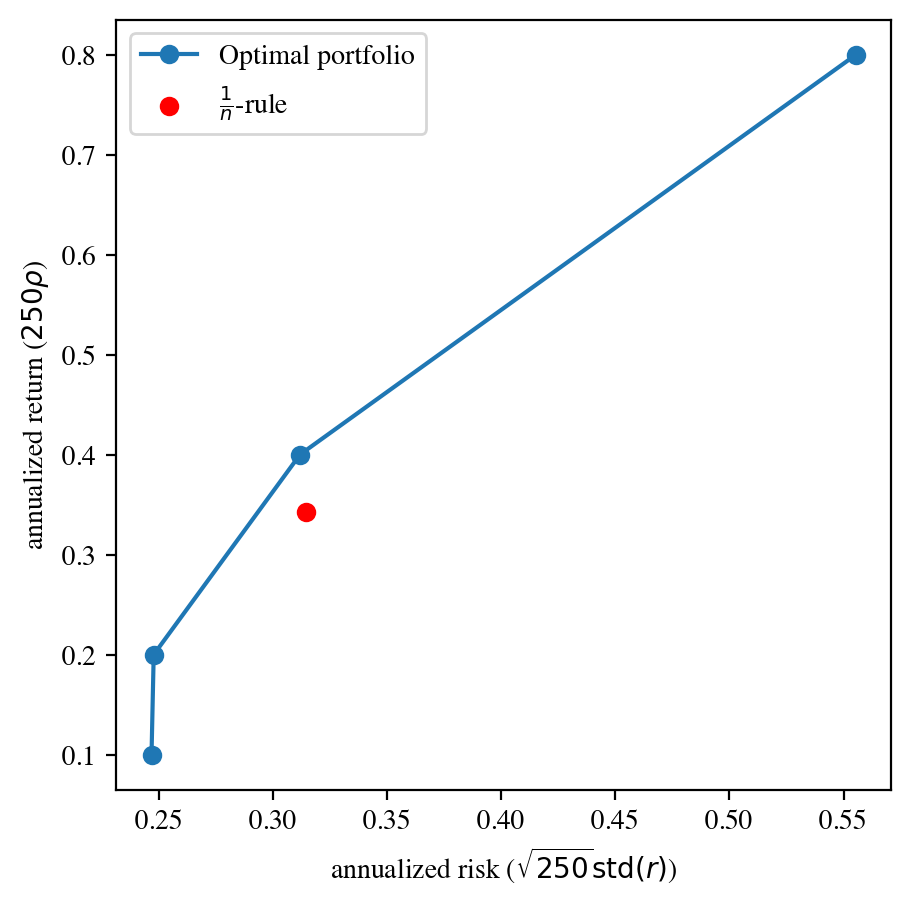

In [19]:
import matplotlib.pyplot as plt
# font settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})
plt.rcParams['text.usetex'] = False


plt.figure(figsize=(5,5),dpi=200)
plt.plot(risks_opt,returns_opt,label=r"Optimal portfolio",marker='o')
plt.scatter(risk_naive,return_naive,color='red',label=r"$\frac{1}{n}$-rule")
plt.xlabel(r"annualized risk ($\sqrt{250} {\sf std}(r)$)")
plt.ylabel(r"annualized return ($250\rho$)")
plt.legend()
plt.show()

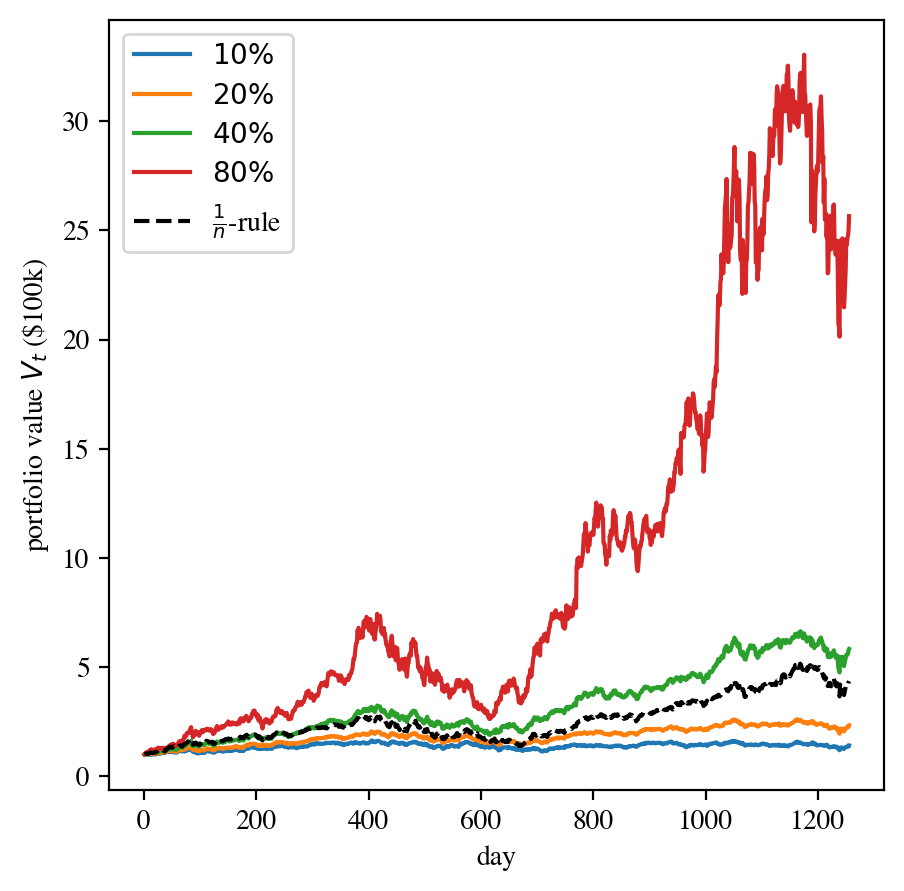

In [20]:
import numpy as np
from numpy.linalg import inv

# annualized target returns
# (10%,20%,40%,80%)
rhos = [0.0004, 0.0008, 0.0016, 0.0032]

# matrix preparation
T, n = R.shape
ones_T = np.ones((T, 1))
ones_n = np.ones((n, 1))
M = np.block([
        [2*R.T@R, R.T@ones_T, ones_n],
        [ones_T.T@R, 0, 0],
        [ones_n.T, 0, 0]
    ])

# Compute V_opt for different rhos
V_opt = []
for i, rho in enumerate(rhos):
    v = np.vstack([
        2*rho*R.T@ones_T,
        [[T*rho]],
        [[1]]
    ])
    # solve the KKT equation
    wstar_z = np.dot(inv(M),v)
    wstar = wstar_z[:n]
    r = R@wstar
    V_opt.append(np.cumprod(1+r))

# Compute V_naive
w_naive = np.ones((n,1))/n
r_naive = R@w_naive
V_naive = np.cumprod(1+r_naive)

plt.figure(figsize=(5,5),dpi=200)
for i, rho in enumerate(rhos):
    plt.plot(np.arange(1, T+1),V_opt[i],label=f"${250*rho*100:.0f}\\%$")
plt.plot(np.arange(1,T+1),V_naive, 'k--',label='$\\frac{1}{n}$-rule',)
plt.xlabel(r'day')
plt.ylabel(r'portfolio value $V_t$ (\$100k)')
plt.legend()
plt.show()